In [1]:
import glob
import xarray as xr
import netCDF4
import h5netcdf
import scipy
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
ds=xr.open_dataset('ready_sic_sst_data.nc')#'../data/ready_sic_sst_data.nc')
ds

<xarray.Dataset> Size: 85MB
Dimensions:    (time: 46, latitude: 160, longitude: 1440)
Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 368B 1979-09-01 1980-09-01 ... 2024-09-01
  * latitude   (latitude) float64 1kB 90.0 89.75 89.5 89.25 ... 50.75 50.5 50.25
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    expver     (time) <U4 736B ...
Data variables:
    sst        (time, latitude, longitude) float32 42MB ...
    sic        (time, latitude, longitude) float32 42MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-25T20:05 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
#Set up datasets
sst=ds['sst']
sic=ds['sic']

In [4]:
#Import pytorch
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
sic.shape
sic = sic.fillna(0)
lat=slice(0,80)
#sic = sic.sel(latitude=lat)

Epoch 30/300, Loss: 0.007182
Epoch 60/300, Loss: 0.002295
Epoch 90/300, Loss: 0.000975
Epoch 120/300, Loss: 0.000686
Epoch 150/300, Loss: 0.000568
Epoch 180/300, Loss: 0.000454
Epoch 210/300, Loss: 0.000348
Epoch 240/300, Loss: 0.000316
Epoch 270/300, Loss: 0.000287
Epoch 300/300, Loss: 0.000299


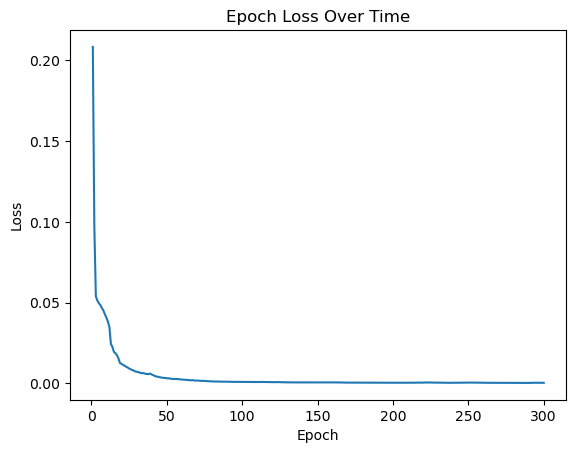

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)  # Output: 16x80x720
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)  # Output: 32x40x360
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # Output: 64x20x180
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # Output: 128x10x90
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 10 * 90, 512)  # Bottleneck

    def forward(self, x):
        #print("Input shape:", x.shape)
        x = torch.relu(self.conv1(x))
        #print("After conv1:", x.shape)
        x = torch.relu(self.conv2(x))
        #print("After conv2:", x.shape)
        x = torch.relu(self.conv3(x))
        #print("After conv3:", x.shape)
        x = torch.relu(self.conv4(x))
        #print("After conv4:", x.shape)
        x = self.flatten(x)
        #print("After flatten:", x.shape)
        x = self.fc(x)
        #print("After fc:", x.shape)
        return x

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(512, 128 * 10 * 90)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(1, 1))
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1, 1))
        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(1, 1))
        self.deconv4 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=(1, 1))
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        #print("Input shape (latent space):", x.shape)
        x = torch.relu(self.fc(x))
        #print("After fc (expanded latent):", x.shape)
        x = x.view(-1, 128, 10, 90)  # Reshape to match the spatial dimensions expected by deconv1
        #print("After reshaping:", x.shape)
        x = torch.relu(self.deconv1(x))
        #print("After deconv1:", x.shape)
        x = torch.relu(self.deconv2(x))
        #print("After deconv2:", x.shape)
        x = torch.relu(self.deconv3(x))
        #print("After deconv3:", x.shape)
        x = self.sigmoid(self.deconv4(x))
        #print("After deconv4 (final output):", x.shape)
        return x

# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

        # Split sic.values into training and testing datasets

sic_values = sic.values
train_data, test_data = train_test_split(sic_values, test_size=0.2, random_state=42)
data=train_data
 

# Normalize and create DataLoader
data = torch.tensor(data).unsqueeze(1)  # Add channel dimension
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Track epoch loss
epoch_losses = []

# Training Loop
epochs = 300
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        inputs = batch[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    epoch_loss = total_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    if (epoch + 1) % (epochs // 10) == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.6f}")

# Plot epoch loss
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Loss Over Time')
plt.show()

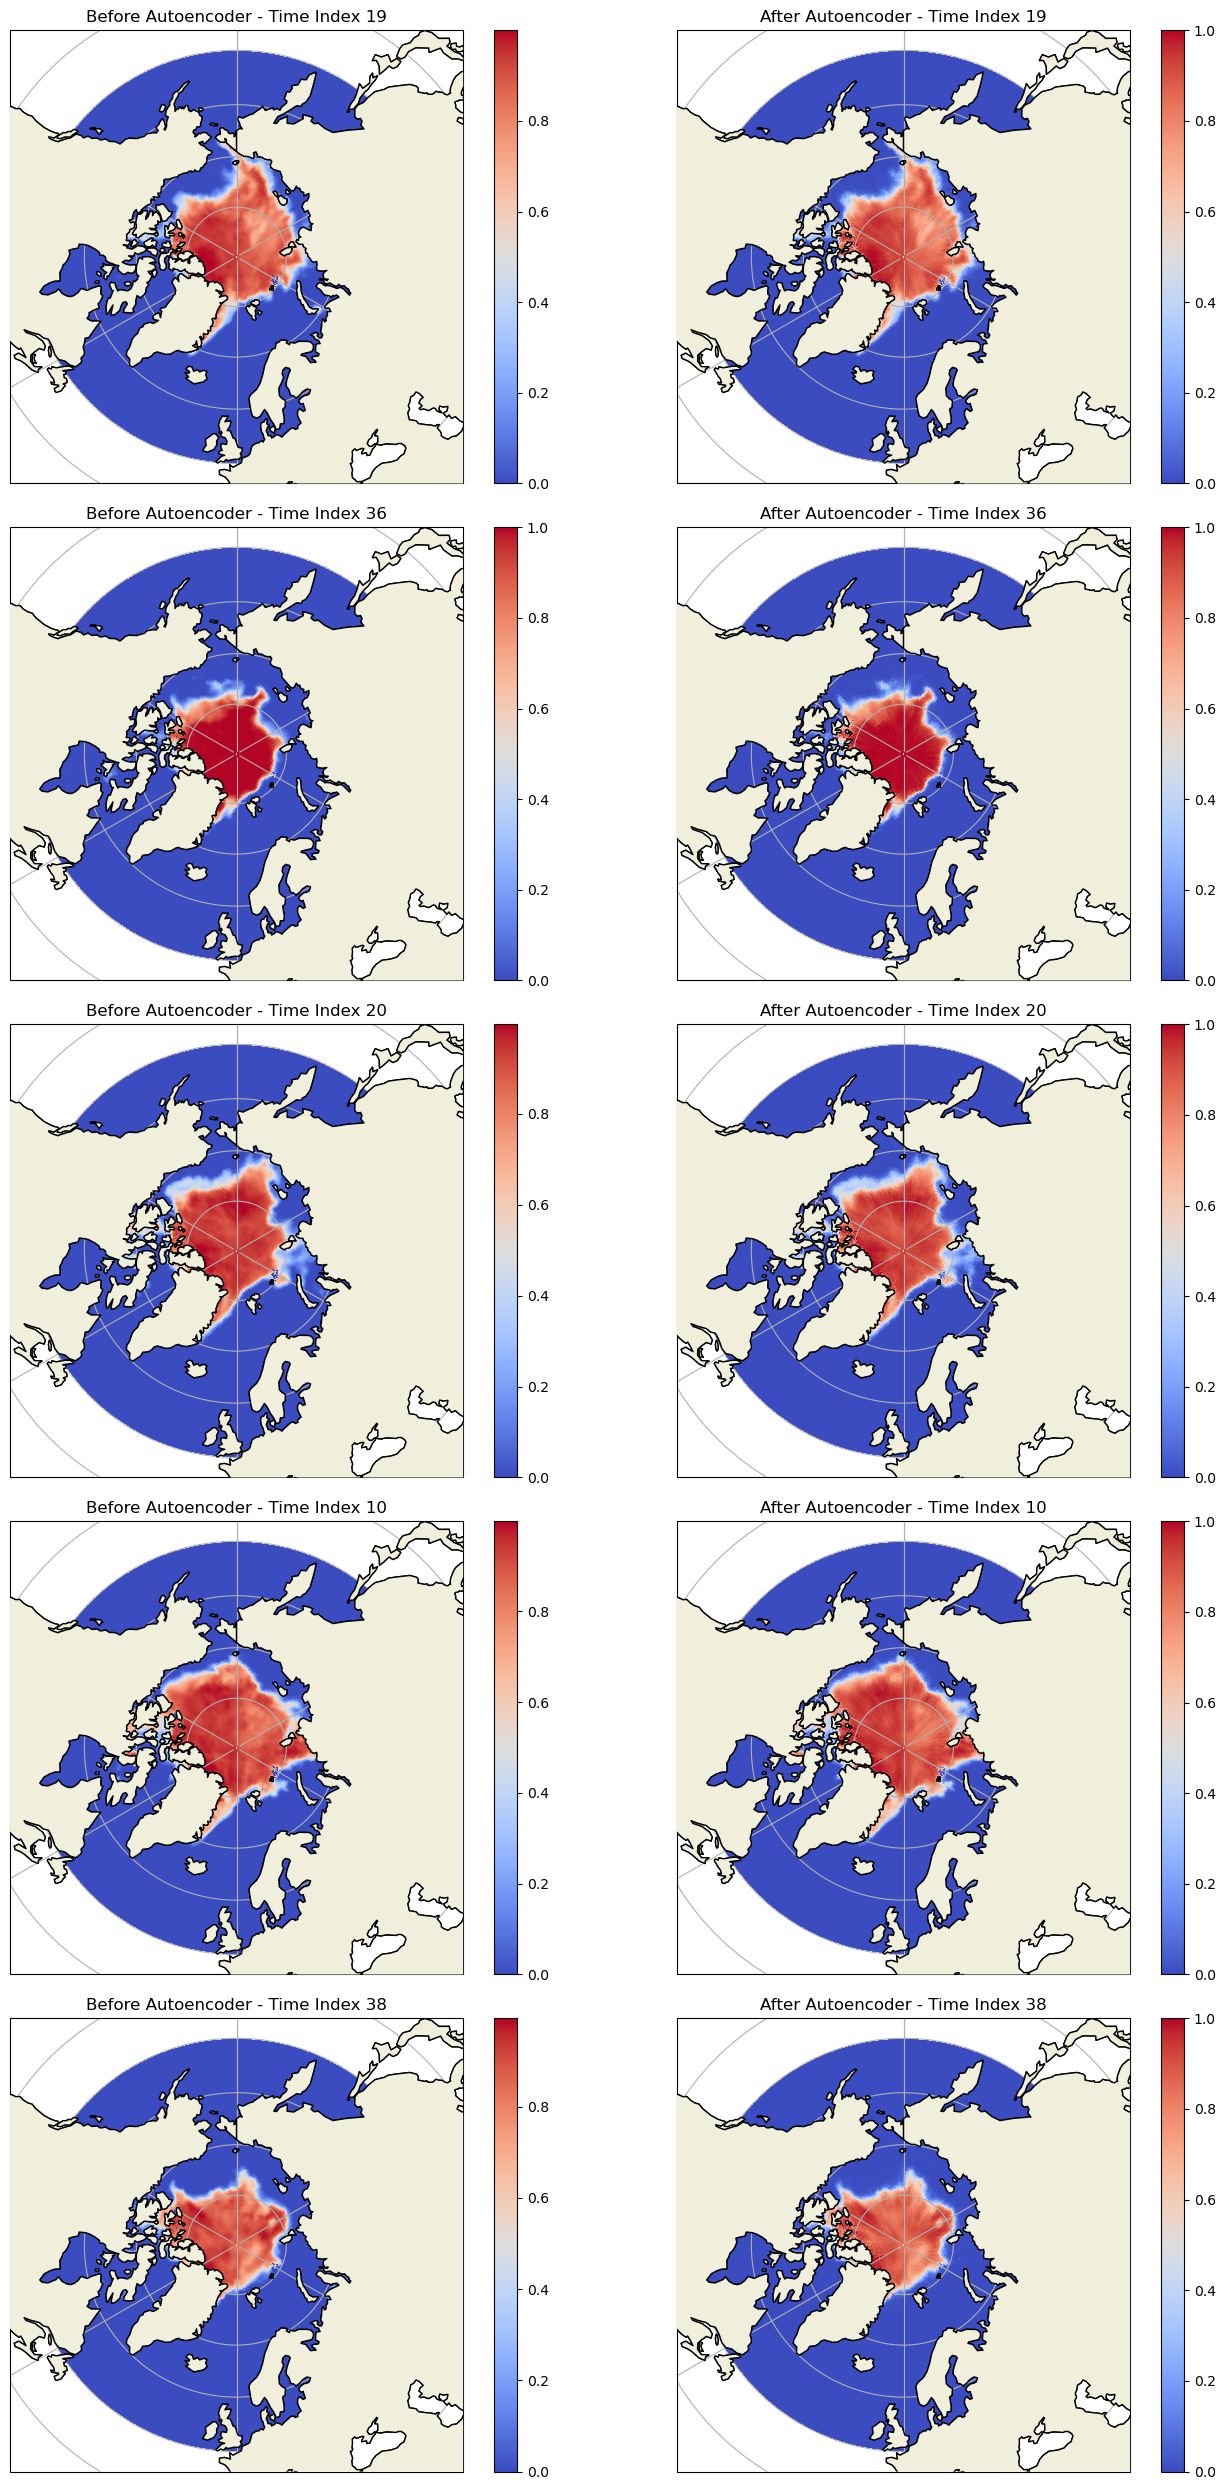

In [15]:
import random

# Function to plot SIC data
def plot_sic(data, title, ax):
    ax.set_title(title)
    ax.coastlines()
    ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
    ax.gridlines()
    sic_plot = ax.pcolormesh(ds.longitude, ds.latitude, data, transform=ccrs.PlateCarree(), cmap='coolwarm')
    plt.colorbar(sic_plot, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

# Select 5 random indices
random_indices = random.sample(range(sic.shape[0]), 5)

# Plot before and after SIC data
fig, axes = plt.subplots(5, 2, subplot_kw={'projection': ccrs.NorthPolarStereo()}, figsize=(15, 25))

for i, idx in enumerate(random_indices):
    # Before Autoencoder
    plot_sic(sic[idx].values, f'Before Autoencoder - Time Index {idx}', axes[i, 0])
    
    # After Autoencoder
    with torch.no_grad():
        sic_input = sic[idx].values[np.newaxis, np.newaxis, :, :]
        sic_input = torch.tensor(sic_input, dtype=torch.float32).to(device)
        sic_output = model(sic_input).cpu().numpy().squeeze()
    plot_sic(sic_output, f'After Autoencoder - Time Index {idx}', axes[i, 1])

plt.tight_layout()
plt.show()

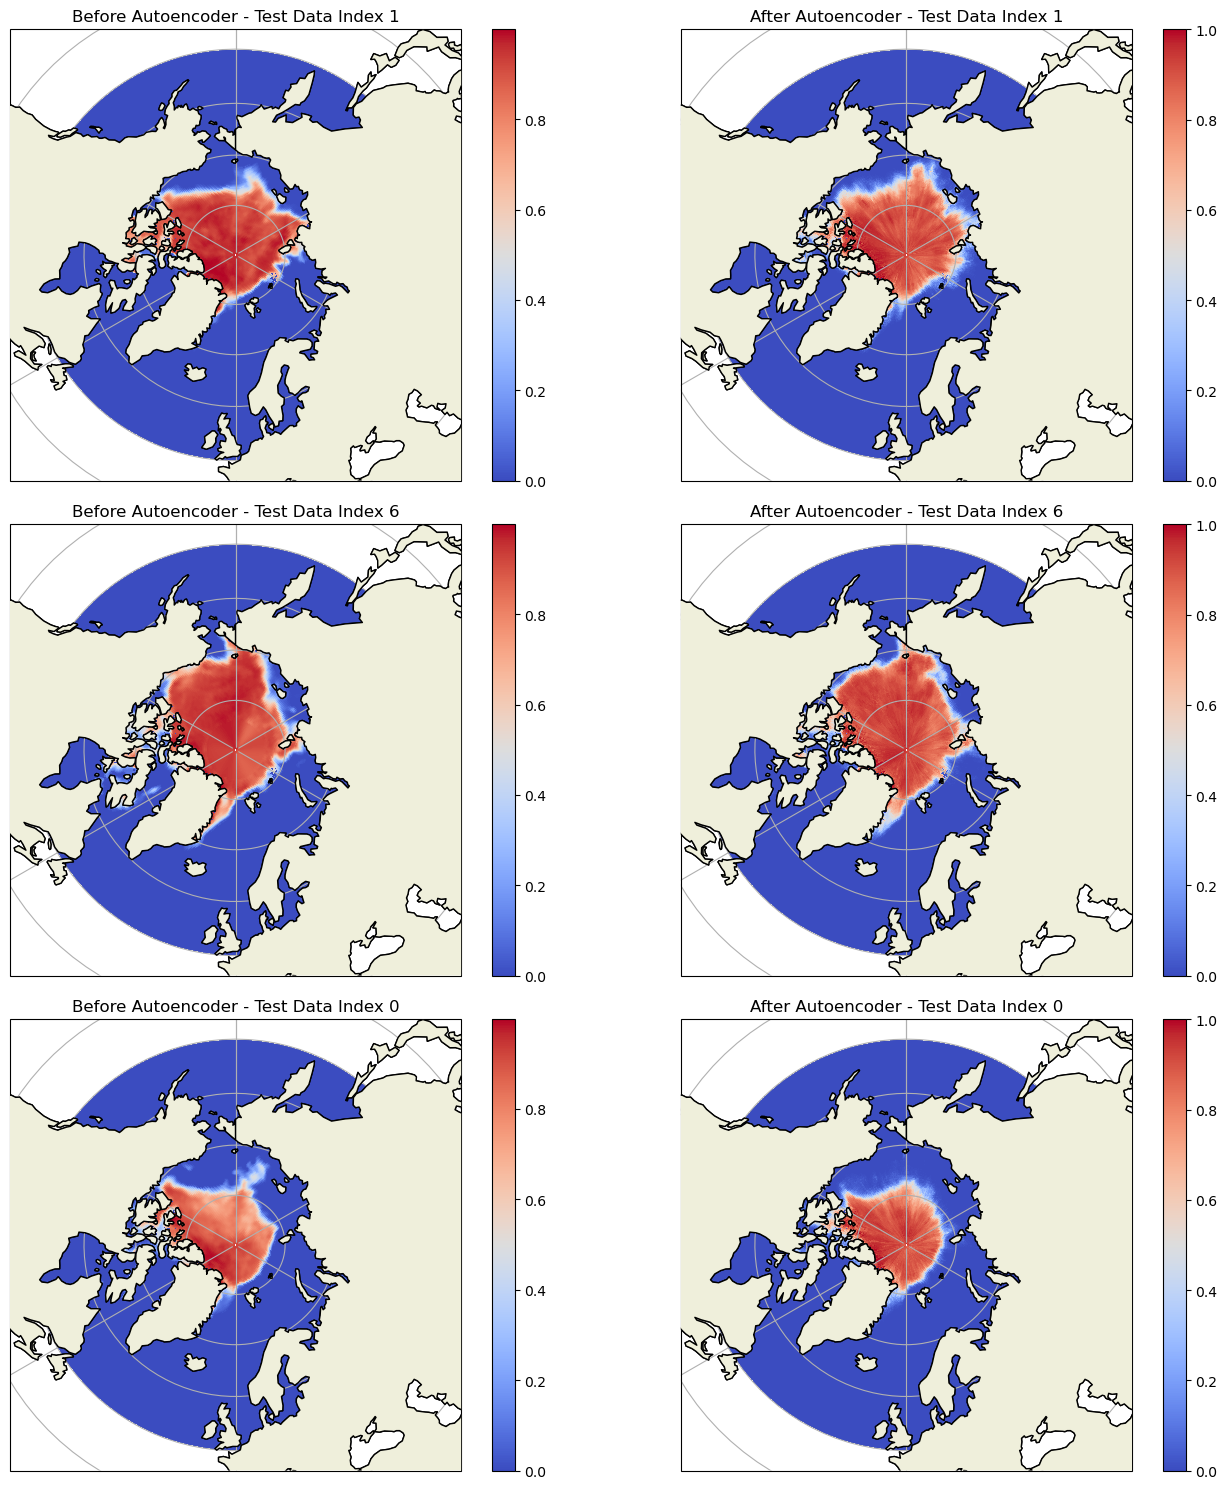

In [17]:
# Select 3 random indices from test_data
random_test_indices = random.sample(range(test_data.shape[0]), 3)

# Plot before and after SIC data for test_data
fig, axes = plt.subplots(3, 2, subplot_kw={'projection': ccrs.NorthPolarStereo()}, figsize=(15, 15))

for i, idx in enumerate(random_test_indices):
    # Before Autoencoder
    plot_sic(test_data[idx], f'Before Autoencoder - Test Data Index {idx}', axes[i, 0])
    
    # After Autoencoder
    with torch.no_grad():
        sic_input = test_data[idx][np.newaxis, np.newaxis, :, :]
        sic_input = torch.tensor(sic_input, dtype=torch.float32).to(device)
        sic_output = model(sic_input).cpu().numpy().squeeze()
    plot_sic(sic_output, f'After Autoencoder - Test Data Index {idx}', axes[i, 1])

plt.tight_layout()
plt.show()